# **Problem set 3** - Machine Learning for Physics and Astronomy 2023/2024, UvA



- The total sheet gives 27 points
- Deadline for submitting your results is **Wed, 24/04/2024, 23:59**
- **IMPORTANT**: Specify if/how AI was used to solve the exercises by filling the corresponding "Usage of AI" comments. Anything between "No" (if applicable) and a short paragraph reflecting how AI was used is fine. Failing to do so faithfully will result in the substraction of points.

## Chapter 5: Gaussian Process Regression (14 points)

### 5.1 Gaussian process regression analytically (4 points)

Let us consider a Gaussian process regression problem with an uncommon but simple kernel function, the constant $\kappa\left(x, x^{\prime}\right)=1$ (as usual, the mean function is $\mu(x)=0$ ). Let us assume we have measurements at two points $x=-1.0, 0.0$, and these measurements are $y=-0.2,0.1$. We can assume measurement uncertainties of $\sigma=0.1$.

1. (4pt) Derive the predicted value of $y$ at $x=0.2$, both in terms of mean value and variance. Do this fully analytically.

For noisy observations (here $\sigma = 0.1$),
<br>
$cov [y|X] = K + \sigma _ y ^2I_N$
<br>
Here, since κ(x,x') = 1, K = $\begin{pmatrix} 1 & 1 \\ 1 & 1 \end{pmatrix}$
<br>
$K_y= \begin{pmatrix} 1.01 & 1 \\ 1 & 1.01 \end{pmatrix}$
<br>
$K_* = \begin{pmatrix} 1 \\ 1 \end{pmatrix}$
<br>
$K_{**} = κ(X_*,X_*) = 1$
<br>
Since $\mu_X$= 0 for all x,
<br>
$\mu_* = K_*^TK_y^{-1}y = \begin{pmatrix} 1 & 1 \end{pmatrix}\begin{pmatrix} 50.248 & -49.751 \\ -49.751 & 50.248 \end{pmatrix} \begin{pmatrix} -0.2 \\ 0.1 \end{pmatrix} = -0.049$
<br>
$\Sigma_* = K_{**} - K_*^TK_y^{-1}K_* = 1 - \begin{pmatrix} 1 & 1 \end{pmatrix}\begin{pmatrix} 50.248 & -49.751 \\ -49.751 & 50.248 \end{pmatrix}\begin{pmatrix} 1 \\ 1 \end{pmatrix} = 1 - 0.99 = 0.01$

**Usage** of AI: None

### 5.2 Gaussian process regression with Numpy  (10 points)

**Reading Material: Murphy 15.1 + 15.2 (up to and including 15.2.3)**

In this exercise, we will be implementing the Gaussian process regression formalism discussed in class.  

Suppose we observe a training set $(\mathbf{x}_i, f_i)$ with $i = 1, \ldots, N$ and where $f_i = f(\mathbf{x}_i)$ is a noise-free observation of the function evaluated at $\mathbf{x}_i$. Each $\mathbf{X}$ has dimensionality $D$. Below is just such a set, with $D = 1$ and $N = 20$.


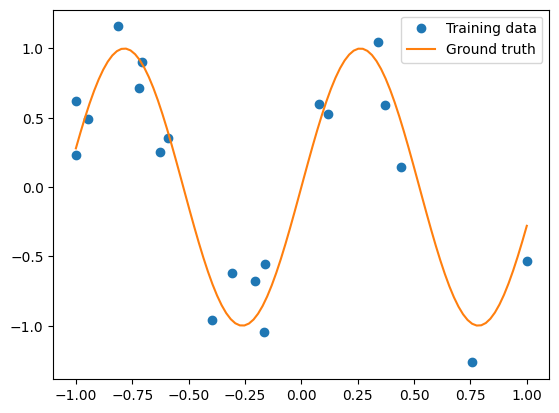

In [168]:
# provided data
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)
x_i = np.random.uniform(-1., 1., 20)
x_i[0] = -1
x_i[-1] = 1
f_i = np.sin(x_i*6)
y_i = f_i + np.random.randn(20)*0.3
x_true = np.linspace(-1, 1, 100)
f_true = np.sin(x_true*6)

plt.plot(x_i, y_i, 'o', label = 'Training data')
plt.plot(x_true, f_true, label = "Ground truth")
plt.legend()

1. **(1pt)** Array preparations
- We need to reformat the training set as $\mathbf{X}$, a $N \times D$ matrix. Reshape the provided $x_i$ set into an $N \times D$ numpy array. Reshape the f_i values into a variable named F, with shape $N \times 1$.
- We will want to evaluate whatever  function we learn using the GP at inputs $\mathbf{X}_*$, with size $N_* \times D$ and predict outputs $\mathbf{f}_*$. In this example, let's predict 100 evenly spaced values for $\mathbf{X}_*$ from -1 to 1, so that when we plot the learned function later, it looks almost continuous. This is our *test* set. Define the variable `X_test` with these specifications, taking care to make it the right shape.

In [169]:
D = 1
N = 20
xreshaped = np.reshape(x_i,(N,D))
F = np.reshape(f_i,(N,1))
X_test = np.linspace(-1,1,100)

2. **(2pt)** Implementation of kernel function

**Background information and assumptions**: Remember from the lectures that the full joint distribution of the training set $\mathbf{f}$ and test set $\mathbf{f_*}$ is given by

   $$
\left(\begin{array}{c}
\mathbf{f} \\
\mathbf{f}_{*}
\end{array}\right) \sim \mathcal{N}\left(\left(\begin{array}{c}
\boldsymbol{\mu} \\
\boldsymbol{\mu}_{*}
\end{array}\right),\left(\begin{array}{cc}
\boldsymbol{K} & \boldsymbol{K}_{*} \\
\boldsymbol{K}_{*}^{T} & \boldsymbol{K}_{* *}
\end{array}\right)\right)
$$

where $\mathbf{K} = \kappa (\mathbf{X}, \mathbf{X})$ is an $N \times N$ matrix, $\mathbf{K}_* = \kappa (\mathbf{X}, \mathbf{X}_*)$ is an $N \times N_*$ matrix, and $\mathbf{K}_{**} = \kappa (\mathbf{X}_*, \mathbf{X}_*)$ is an $N_* \times N_*$ matrix, based on the kernel function $\kappa( . )$.

For this exercise, we will use the **radial basis function** (RBF) kernel, given by
$$
\kappa\left(\mathbf{x}_i, \mathbf{x}_i^{\prime}\right)= \alpha^2 \exp \left(-\frac{\left\|\mathbf{x}_i-\mathbf{x}_j\right\|^{2}}{2 l^{2}}\right)\;.
$$
(we have renamed the bandwidth parameter to be $l$ instead of the $\sigma$ in class because another $\sigma$ will enter the story later). The double bars indicate the Euclidean distance. We also introduced the parameter $\alpha$. Note that$\alpha^2$ corresponds to the variance of the GP.

The kernel function $\kappa$ recieves two points $\mathbf{x}_i$ and $\mathbf{x}_j$ and returns the function evaluated at those points. But we will need to define $\mathbf{K}$, a matrix which will have dimensions that are "total amount of $\mathbf{x}_i$'s $\times$  total amount of $\mathbf{x}_j$'s". So, just this once, I will encourage you to do something in an actual nested for-loop (just this once!) for the sake of clarity. Every other time in this course, please vectorize your functions.

**Task**: Implement the following functions. `kappa(x_i, x_j, l, alpha)` should return an element-wise comparison of two individual examples $\mathbf{x}_i$ and $\mathbf{x}_j$. `Kernel(X1, X2)` should return the full matrix $\mathbf{K}$ and should be implemented with two nested for-loops.

In [170]:
def kappa(x_i, x_j, l, alpha):
    const = alpha**2
    expterm = np.linalg.norm(x_i-x_j)**2/(2*l**2)
    return const*np.exp(-expterm)

def Kernel(X1, X2, l, alpha):
    N = len(X1)
    M = len(X2)
    Kernel_array = np.zeros((N,M))
    for i in range(0,N):
      for j in range(0,M):
        Kernel_array[i][j] = kappa(X1[i],X2[j],l,alpha)
    return Kernel_array

3. **(1pt)** With our kernel function in hand, let's make a plot of what it looks like! Viusalize the kernel array evaluated for all values in X_test (with X_test inputed twice) using the `plt.imshow()` function for a few (~3) reasonable values of $l$. What does the $l$ parameter represent, intuitively?  [Read about plt.imshow here.](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html).

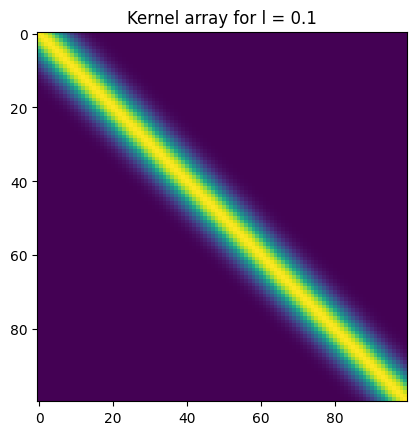

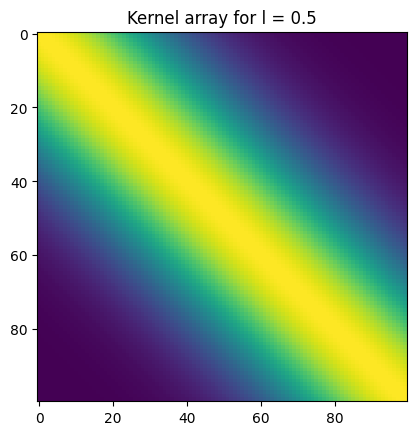

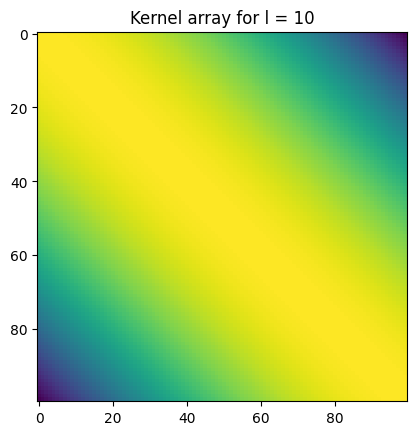

In [171]:
testkernel1 = Kernel(X_test,X_test,0.1,0.5)
testkernel2 = Kernel(X_test,X_test,0.5,0.5)
testkernel3 = Kernel(X_test,X_test,10,0.5)
plt.imshow(testkernel1)
plt.title('Kernel array for l = 0.1')
plt.show()
plt.imshow(testkernel2)
plt.title('Kernel array for l = 0.5')
plt.show()
plt.imshow(testkernel3)
plt.title('Kernel array for l = 10')
plt.show()
# Your code

Intuitively, the bandwidth parameter l decides the level of non linearity of the decision boundary. Higher l implies a less linear boundary for the model.  

4. **(2pt)** Now it's time for Gaussian process regression!

Let's start with a recap.

**Noise-free case**. In the absence of measurement noise, the distribution of function values $\mathbf{f}_\ast$ at points $\mathbf{X}_\ast$, conditioned on training data $\mathbf{X}$ and observed function values $\mathbf{f}$, is given by $\mathbf{f}_* \sim \mathcal{N}(\mathbf{f}_*| \boldsymbol{\mu}_*,\boldsymbol{\Sigma}_*)$, where
$$
\boldsymbol{\mu}_{*}=\boldsymbol{K}_{*}^{T} \boldsymbol{K}^{-1} \mathbf{f} \quad \text { and } \quad \boldsymbol{\Sigma}_{*}=\boldsymbol{K}_{* *}-\boldsymbol{K}_{*}^{T} \boldsymbol{K}^{-1} \boldsymbol{K}_{*}
$$
and where
$$
\mathbf{K}=\kappa(\mathbf{X}, \mathbf{X}), \mathbf{K}_{*}=\kappa\left(\mathbf{X}, \mathbf{X}_{*}\right), \text { and } K_{* *}=\kappa\left(\mathbf{X}_{*}, \mathbf{X}_{*}\right)
$$
based on the kernel function $\kappa(\cdot, \cdot)$.

Remember that $\mathbf{f}_* \sim \mathcal{N}(\mathbf{f}_*| \boldsymbol{\mu}_*,\boldsymbol{\Sigma}_*)$ implicitely defines a posterior over **functions**, since we are free to chose $\mathbf{X}_\ast$.

**Noisy case**.  Suppose that we observe now a noisy version of the underlying function.
   $$y = f(\mathbf{X}) + \epsilon \\ \text{where} \\ \epsilon \sim \mathcal{N}(0, \sigma_y^2)$$
The above discussion remains untouched, except that the mean and covariance are in this case given by$$
\boldsymbol{\mu}_{*}=\boldsymbol{K}_{*}^{T} \boldsymbol{K}_{y}^{-1} \mathbf{f} \quad \text { and } \quad \boldsymbol{\Sigma}_{*}=\boldsymbol{K}_{* *}-\boldsymbol{K}_{*}^{T} \boldsymbol{K}_{y}^{-1} \boldsymbol{K}_{*}
$$
where now the covariance of the training data has an additional noise term,
$$
\mathbf{K}_{y} \equiv \mathbf{K}+\sigma_{y}^{2} \mathbf{I}_{N}
$$

**Your Task**

- Implement the function `posterior` below. `x_test` will be $\mathbf{X}_*$, `x_train` is $\mathbf{X}$ and `t_train` will be the corresponding training values $f(\mathbf{x}_i)$, `l` is the bandwidth parameter and `alpha` the (square root of the) variance of the RBF kernel.  Furthermore, `sigma_y` is the noise.
- The function should return the values (1) $\boldsymbol{\mu}_*$, (2)  $\boldsymbol{\Sigma}_*$, i.e. the parameters over the multivariate Gaussian posterior, and (3) the log marginal likelihood (see lecture slides).
   
   Hints: This function should not be long (max 10 lines), now that you have your kernel function in hand. If it is a long function, you may be doing something wrong. As a debugging tip: you can verify that you have the correct dimensions for $\mathbf{K}$, $\mathbf{K}_*$, and $\mathbf{K}_{**}$ by calling `print(K.shape)`.


In [172]:
def posterior(x_test, x_train, t_train, l, sigma_y, alpha):
    K = Kernel(x_train,x_train,l,alpha)
    K_star = Kernel(x_train,x_test,l,alpha)
    K_star_star = Kernel(x_test,x_test,l,alpha)
    K_y = K + sigma_y**2* np.eye(len(x_train))
    invKy = np.linalg.inv(K_y)
    mu_star = K_star.T @ invKy @ t_train
    sigma_star = K_star_star - K_star.T @ invKy @ K_star
    likelihood = -1/2 * (t_train.T @ invKy @ t_train) - 1/2 * np.log(np.linalg.det(K_y)) - len(x_train)/2 * np.log(2*np.pi)
    return mu_star, sigma_star, likelihood

5. **(2pt)** Run your posterior function on the training data provided earlier in this exercise, using `l=0.1`, `alpha = 0.5` and `sigma_y=0.3`, and plot the results.

- Plot 3 samples of the resulting function from the posterior on the same plot as the original training data.
- Plot the $2\sigma$ uncertainty band, all in the same one plot.
- Describe in some detail the certain vs uncertain regions of the plot. Connect back to the material discussed in class.

Notes: You can produce samples by calling `np.random.multivariate_normal`.  [You can read documentation about this function here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html). *Note the types of dimensions that this function needs for the input parameters.*

   The $2 \sigma$ uncertainty interval of the multivariate Gaussian can be calculated as `2*np.sqrt(np.diag(cov))`. Use this value to plot the uncertainty region for your posterior. The function [plt.fill_between](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html) might be useful here.


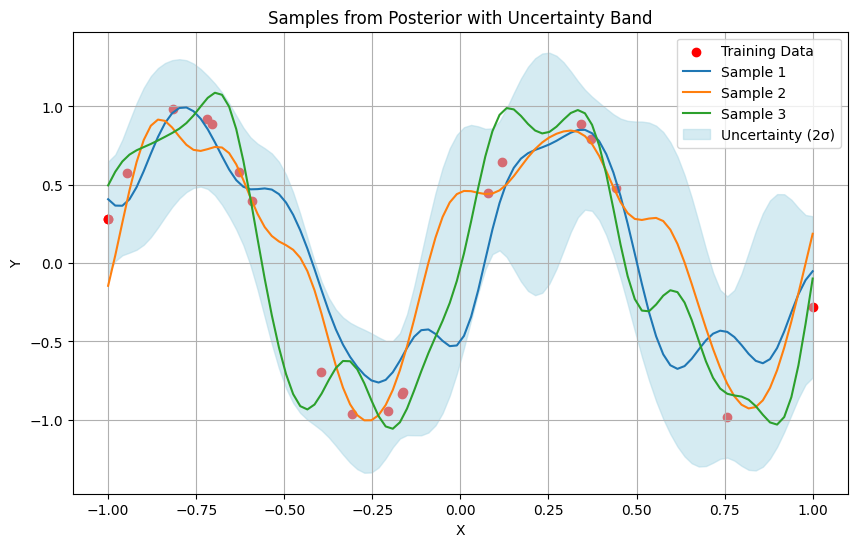

In [173]:
N = 20
D = 1
X_test = np.linspace(-1,1,100)
xtestres = np.reshape(X_test,(100,D))
xtrainreshaped = np.reshape(x_i,(N,D))
F = np.reshape(f_i,(N,1))
l = 0.1
alpha = 0.5
sigma_y = 0.3
mu_star, Sigma_star, likelihood1 = posterior(xtestres,xtrainreshaped,F,l,sigma_y,alpha)

samples = np.random.multivariate_normal(mu_star[:,0],Sigma_star,size = 3)
plt.figure(figsize=(10, 6))
plt.scatter(xtrainreshaped, F, color='red', label='Training Data')

# Plot samples
for i in range(3):
    plt.plot(xtestres, samples[i], label=f'Sample {i+1}')

# Plot uncertainty band (2σ)
plt.fill_between(X_test, mu_star[:,0] - 2 * np.sqrt(np.diag(Sigma_star)), mu_star[:,0] + 2 * np.sqrt(np.diag(Sigma_star)), color='lightblue', alpha=0.5, label='Uncertainty (2σ)')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples from Posterior with Uncertainty Band')
plt.legend()
plt.grid(True)
plt.show()


Your answer

6. **(2pt)** Via trial-and-error, grid or random scan, identify good hyper parameters `l`, `alpha` and `sigma_y`.  They should lead to a large log marginal likelihood. Plot the results of a few settings of the hyperparameters that you tried.

- What are the best-fit parameters that you find?
- What happens when `alpha` is too large or too small?
- What happens when `l` is too large or too small?

In [174]:
import random

# Define ranges for hyperparameters
l_range = (0.01, 5)
alpha_range = (0.1, 5)
sigma_y_range = (0.01, 0.5)

# Number of random samples
num_samples = 100

# Initialize variables to store best hyperparameters and corresponding log marginal likelihood
best_params = None
best_log_likelihood = float('-inf')

# Perform random search
for _ in range(num_samples):
    # Randomly sample hyperparameters from the predefined ranges
    l = random.uniform(*l_range)
    alpha = random.uniform(*alpha_range)
    sigma_y = random.uniform(*sigma_y_range)

    # Calculate log marginal likelihood
    mu_star, Sigma_star, log_likelihood = posterior(xtestres, xtrainreshaped, F, l, sigma_y,alpha)

    # Update best hyperparameters if log likelihood is improved
    if log_likelihood > best_log_likelihood:
        best_log_likelihood = log_likelihood
        best_params = (l, sigma_y, alpha)


Best Hyperparameters (l, alpha, sigma_y): (0.361654072398243, 0.04809814156136277, 4.167191119508807)
Best Log Marginal Likelihood: [[5.15162557]]


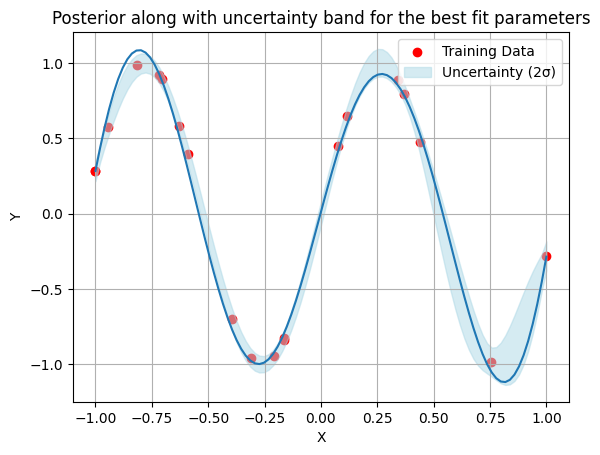

In [175]:
print("Best Hyperparameters (l, alpha, sigma_y):", best_params)
print("Best Log Marginal Likelihood:", best_log_likelihood)
mu_star, Sigma_star, likelihood1 = posterior(xtestres,xtrainreshaped,F,best_params[0],best_params[1],best_params[2])
plt.scatter(xtrainreshaped, F, color='red', label='Training Data')
samples = np.random.multivariate_normal(mu_star[:,0],Sigma_star,size = 1)
plt.plot(xtestres, samples.T)
# Plot uncertainty band (2σ)
plt.fill_between(X_test, mu_star[:,0] - 2 * np.sqrt(np.diag(Sigma_star)), mu_star[:,0] + 2 * np.sqrt(np.diag(Sigma_star)), color='lightblue', alpha=0.5, label='Uncertainty (2σ)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Posterior along with uncertainty band for the best fit parameters')
plt.legend()
plt.grid(True)
plt.show()

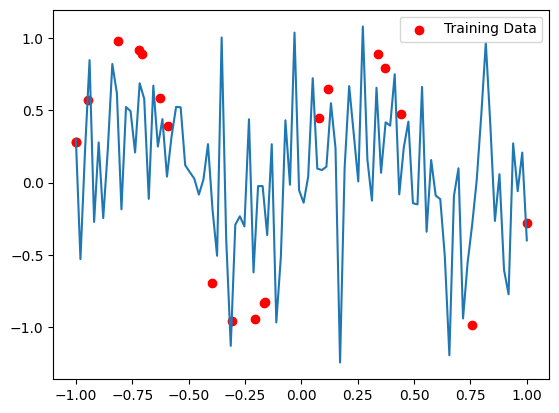

In [176]:
#Sample Plots
l = 0.01
alpha = 0.5
sigma = 0.3
mu_star, Sigma_star, likelihood1 = posterior(xtestres,xtrainreshaped,F,l,sigma,alpha)
plt.scatter(xtrainreshaped, F, color='red', label='Training Data')
samples = np.random.multivariate_normal(mu_star[:,0],Sigma_star,size = 1)
plt.plot(xtestres, samples.T)
plt.legend()
plt.show()

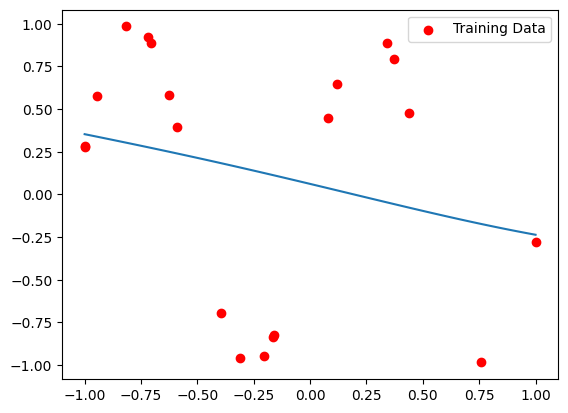

In [177]:
#Sample Plots
l = 2.0
alpha = 0.5
sigma = 0.3
mu_star, Sigma_star, likelihood1 = posterior(xtestres,xtrainreshaped,F,l,sigma,alpha)
plt.scatter(xtrainreshaped, F, color='red', label='Training Data')
samples = np.random.multivariate_normal(mu_star[:,0],Sigma_star,size = 1)
plt.plot(xtestres, samples.T)
plt.legend()
plt.show()

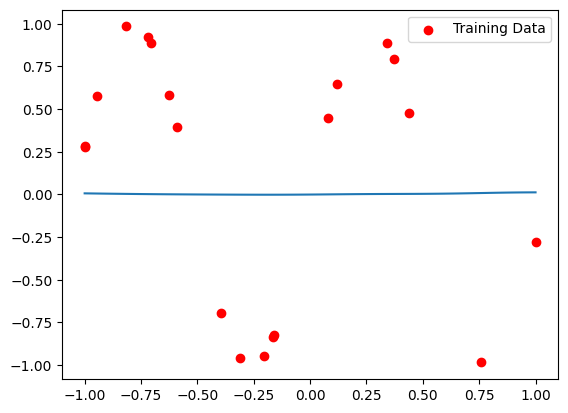

In [178]:
#Sample Plots
l = 0.4
alpha = 0.01
sigma = 0.3
mu_star, Sigma_star, likelihood1 = posterior(xtestres,xtrainreshaped,F,l,sigma,alpha)
plt.scatter(xtrainreshaped, F, color='red', label='Training Data')
samples = np.random.multivariate_normal(mu_star[:,0],Sigma_star,size = 1)
plt.plot(xtestres, samples.T)
plt.legend()
plt.show()

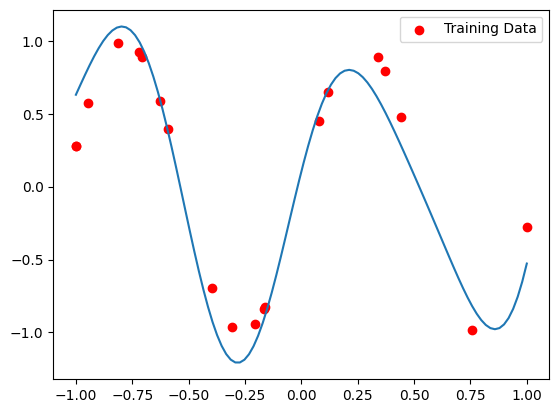

In [203]:
#Sample Plots
l = 0.4
alpha = 4.0
sigma = 0.3
mu_star, Sigma_star, likelihood1 = posterior(xtestres,xtrainreshaped,F,l,sigma,alpha)
plt.scatter(xtrainreshaped, F, color='red', label='Training Data')
samples = np.random.multivariate_normal(mu_star[:,0],Sigma_star,size = 1)
plt.plot(xtestres, samples.T)
plt.legend()
plt.show()

Making l too small increases the "noisy" sinusoidal nature of the fit, while a large l gives a flat line essentially (no higher polynomial orders). Increasing alpha increases the "broadness" of the polynomial fit.

**Usage** of AI: Used ChatGPT for creating the posterior function plot in Q5, to define K_y in the posterior function and for the random scan. No AI used for questions 1 to 3.

## Chapter 6: Logistic regression - classification (13 points)


### 6.1 Likelihoods (2 points)

2. **(2 pt)** Starting with the likelihood of the binary logistic regression
$$
p(\mathbf{t} | \mathbf{w})=\prod_{n=1}^{N} y_{n}^{t_{n}}\left\{1-y_{n}\right\}^{1-t_{n}} \, ,
$$
show that the negative logarithm of the likelihood gives the *binary cross-entropy* error and that the derivative of the cross entropy error is
$$
\nabla E(\mathbf{w})=\sum_{n=1}^{N}\left(y_{n}-t_{n}\right) \phi_{n} \, .
$$


Taking negative logarithm of a product turns it into a sum.
<br>
$-ln(p(t|w)) = \sum_{n=1}^{N} t_n ln(y_n) + (1-t_n) ln (1-y_n)$
<br>
This is the binary cross-entropy error $E(\textbf{w})$.
<br>
We know, $y_n = \sigma(w^T \phi_n)$
<br>
$\nabla E(w) = \sum_{n=1}^{N} (t_n \frac{d ln(y_n)}{dw} + (1-t_n) \frac{d ln(1-y_n)}{dw})$
<br>
$\frac{d ln(y_n)}{dw} = \frac{d}{dw}ln \frac{1}{1+e^{-w^T\phi_n}} = \frac{\phi_n}{1+e^{w^T\phi_n}}$
<br>
Similarly,
$\frac{d ln(1-y_n)}{dw} = -\frac{\phi_n e^{w^T\phi_n}}{1+e^{w^T\phi_n}}$
<br>
$t_n \frac{d ln(y_n)}{dw} + (1-t_n) \frac{d ln(1-y_n)}{dw} = t_n\frac{\phi_n}{1+e^{w^T\phi_n}} + (1-t_n)(-\frac{\phi_n e^{w^T\phi_n}}{1+e^{w^T\phi_n}}) = t_n \phi_n - \frac{\phi_n e^{w^T\phi_n}}{1+e^{w^T\phi_n}}$
<br>
This is equivalent to $\phi_n(t_n - \frac{e^{w^T\phi_n}}{1+e^{w^T\phi_n}}) = \phi_n (t_n-y_n)$
<br>
Therefore,$\nabla E(w) = \sum_{n=1}^{N}\phi_n (t_n-y_n)$

**Usage** of AI: None

### 6.2 Logistic Regression With Numpy (9 points)

*Murphy 8.2, 8.3.2; Bishop 3.1.3, 4.3.2*

In this exercise, we will implement logistic regression to predict the gender of a person based on their height and weight. We will first do this with regular python and numpy and then introduce [PyTorch](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html), the machine learning package that will be used for the remainder of the class.

First, let's import some data.

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

In [181]:
# Import training data
# This will donwload the training data to the virtual colab data folder
# Colab deletes the stored files every time you close your browser, so make sure to run this cell every time
!wget https://raw.githubusercontent.com/johnmyleswhite/ML_for_Hackers/master/02-Exploration/data/01_heights_weights_genders.csv

--2024-04-25 14:18:38--  https://raw.githubusercontent.com/johnmyleswhite/ML_for_Hackers/master/02-Exploration/data/01_heights_weights_genders.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418121 (408K) [text/plain]
Saving to: ‘01_heights_weights_genders.csv.3’

01_heights_weights_ 100%[===================>] 408.32K  --.-KB/s    in 0.03s   

2024-04-25 14:18:38 (11.5 MB/s) - ‘01_heights_weights_genders.csv.3’ saved [418121/418121]



In [182]:
# Read training data
# Now you have access to the label T (0 for Male, 1 for Female), height, and weight for 10,000 data points
data = pd.read_csv("01_heights_weights_genders.csv")
T = np.array([0. if x=='Male' else 1. for x in data['Gender'].values])
H = data['Height'].values
W = data['Weight'].values

print(H.mean())
print(W.mean())

66.36755975482124
161.44035683283076


1. **(1 pt)** Before we continue, we need to **scale** our data to be in similar ranges. Machine learning algorithms will not work well if the ranges of each dimension are very different. Taking a look at our data, the mean value for height is 66.36 (inches), while the mean for weight is 161 (lbs). These are incompatible and will lead to poor performance. Therefore, before we continue define new variables `H_scaled` and `W_scaled` such that they are [standardized](https://en.wikipedia.org/wiki/Feature_scaling). Also feel free to spend a few minutes reading about other feature scaling options.

In [183]:
# Your code
H_scaled = (H - H.mean())/(H.std())
W_scaled = (W - W.mean())/(W.std())
Hmale_scaled = H_scaled[T==0]
Wmale_scaled = W_scaled[T==0]
Hfemale_scaled = H_scaled[T==1]
Wfemale_scaled = W_scaled[T==1]

2. **(0.5 pt)** Make a scatter plot of your data, showing the label of the data in color.


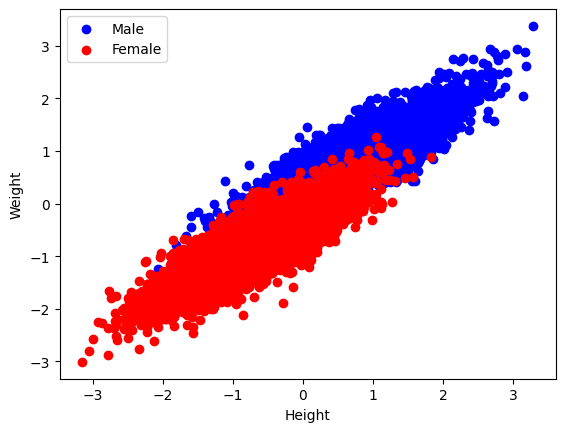

In [184]:
# Your code
plt.scatter(Hmale_scaled,Wmale_scaled,color='blue',label='Male')
plt.scatter(Hfemale_scaled,Wfemale_scaled,color='red',label='Female')
plt.ylabel('Weight')
plt.xlabel('Height')
plt.legend()
plt.show()

3. **(1 pt)** Currently, our target vector has shape (N,). However, a subtle point of numpy arrays: they can't be one-dimensional if you want to take dot products, so we need to reshape our target array into an (N,1) shape. Additionally, we need to turn our input values array from the two (N,) arrays into a singular array of shape (N,2), where 2 is the number of features we have. Perform this operation below.

In [185]:
N=len(T)
target_reshaped = T.reshape(-1, 1)
input_values = np.column_stack((H_scaled, W_scaled))

4. **(2 pt)** Now we will move onto implementing all that is needed to find an optimal solution for logistic regression using gradient descent.  Remember that our model is defined by
$$
a_n = \boldsymbol{w}^T\boldsymbol{\phi}_n \, ,
$$
$$
y_n = \sigma (a_n) \, .
$$
To start, we will need access to our loss function and our sigmoid. In addition, we will need access to our basis functions $\boldsymbol{\phi}_n$. In this case, $\boldsymbol{\phi}_n = [1, \boldsymbol{x}_n]$ so that we extend our model to include a bias. Implement these below.

In [186]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def loss(t, y):
    # Your code

    # Binary Cross Entropy between vector of targets t and vector of predictions y
    # be mindful to add a small value epsilon to any place that might pose numerical instabilities
    # i.e. log(0) would be problematic...
    epsilon = 1e-10  # Avoid division by zero or taking log of zero
    loss = -np.sum(t * np.log(y + epsilon) + (1 - t) * np.log(1 - y + epsilon))
    return loss

def phi(x):
    return np.column_stack((np.ones(len(x)), x))
    #return np.hstack((np.ones((len(x), 1)), x.reshape(-1, 1)))

5. **(2 pt)** Next, we implement our gradient descent. Define a function called `gradient_descent` that takes as input the dataset transformed and in the form of basis $\boldsymbol{\phi}$, the target values, the initial values of the parameters $\boldsymbol{w}$, the number of iterations to perform, and the learning rate. It should return the loss history (the value of the loss at each iteration step) as well as the final value of $\boldsymbol{w}$.

In [187]:
def gradient_descent(X, y, w_initial, num_iterations, learning_rate):

    loss_history = []  # To store the loss value at each iteration

    w = w_initial.copy()  # Initialize weights

    for _ in range(num_iterations):
        # Compute the logits (raw predictions)
        logits = np.dot(X, w)

        # Compute the predicted probabilities using sigmoid function
        y_pred = sigmoid(logits)

        # Compute the gradient of the loss function with respect to parameters w
        gradient = np.dot(X.T, (y_pred - y)) / len(y)

        # Update parameters w using gradient descent
        w -= learning_rate * gradient

        # Compute the loss and append to loss history
        loss1 = loss(y,y_pred)
        loss_history.append(loss1)

    return loss_history, w

6. **(1 pt)**  Now we have all the building blocks and are ready to train! Below we do a little bit of preprocessing and initialization. Fill in under the instructions below and train your model for 1500 iterations. Experiment a little bit with the value for the learning rate, though a value of  0.0001 is a good starting point.

In [188]:
# Transform X into phi using the function you wrote above
# Question: What are the dimensions of phi_x?
phi_x = phi(input_values)
print(phi_x.shape)
# Your answer

# In order to start gradient descent, we initialize our parameters w_init, typically with small values
# Question: Why would initializing with all zeroes be potentially problematic?
w_init = np.random.randn(phi_x.shape[1]) * 0.01
num_iterations = 15000
learning_rate = 0.0001
# Call your gradient_descent function here using the intiailizations from above
# Your code
loss_history, w_final = gradient_descent(phi_x, T, w_init, num_iterations, learning_rate)

(10000, 3)


The shape of phi_x is (10000,3)
Initializing with all zeroes can be problematic as we are taking logarithms while computing loss, and ln(0) is not defined.

7. **(0.5 pt)** Plot your loss as a function of iteration. Have the values of the weights converged yet? How can you tell?

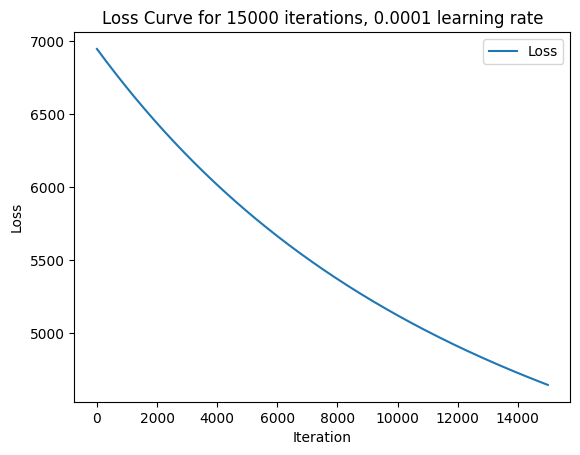

In [189]:
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve for 15000 iterations, 0.0001 learning rate')
plt.legend()
plt.show()

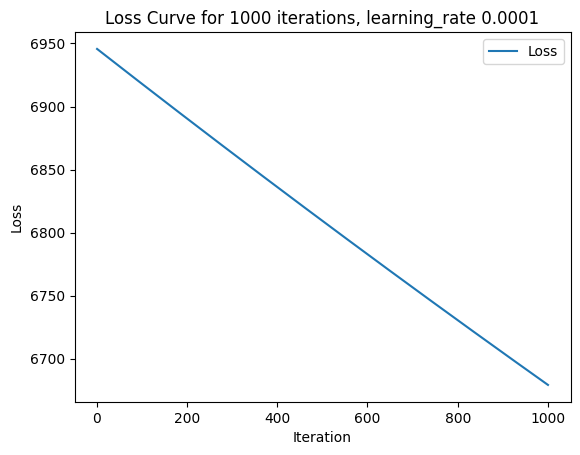

In [190]:
num_iterations = 1000
learning_rate = 0.0001

# Your answer
loss_history, w_final = gradient_descent(phi_x, T, w_init, num_iterations, learning_rate)
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve for 1000 iterations, learning_rate 0.0001')
plt.legend()
plt.show()

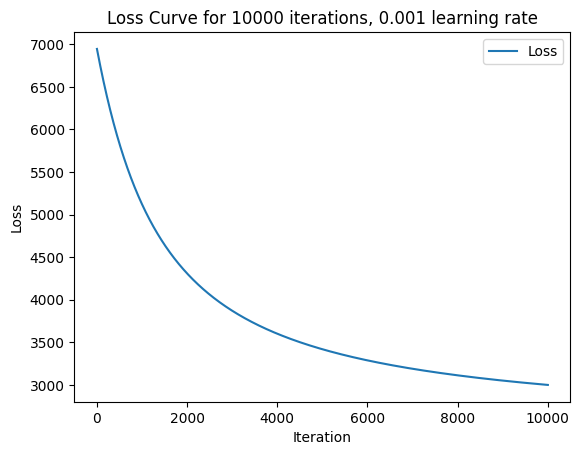

In [191]:
num_iterations = 10000
learning_rate = 0.001

# Your answer
loss_history, w_final = gradient_descent(phi_x, T, w_init, num_iterations, learning_rate)
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve for 10000 iterations, 0.001 learning rate')
plt.legend()
plt.show()

The values of the weights do converge as the loss exponentially drops off as the weights are recalculated over iterations (especially for more than about 15000 iterations, the convergence is less for 1000 iterations).

8. **(1 pt)** Make a scatter plot of your data, but now showing the output of your logistic regression model as the output.

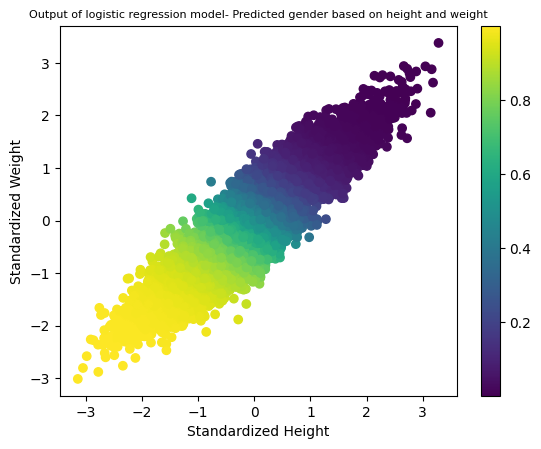

In [192]:
pred = sigmoid(np.dot(phi_x,w_final))
plt.scatter(phi_x[:,1],phi_x[:,2],c=pred,cmap='viridis')
plt.colorbar()
plt.title('')
plt.xlabel('Standardized Height')
plt.ylabel('Standardized Weight')
plt.title('Output of logistic regression model- Predicted gender based on height and weight',fontsize=8)
plt.show()

**Usage** of AI: Used ChatGPT for loss function, gradient descent function and plotting.

### 6.3 A pytorch crash-course: Logistic Regression With Pytorch - towards artificial neurons (2 points)

**This exercise is highly guided for you to get familiar with PyTorch, carefully read as it will be relevant in the next weeks.**

Numpy is a great framework for general scientific computing, but it cannot utilize GPUs to accelerate numerical computations nor is it ideal for machine learning specific tasks. We will therefore use Pytorch, a widely used deep learning package. In fact, logistic regression can be seen as the minimal example of a neural network: it consist of a single neuron with a sigmoid activation function. You will learn more about neural networks later in the course. \\
The most important basic concept is that a Pytorch tensor is the same as a numpy array. In this worked out example we will implement logistic regression in Pytorch in the setting of the previous exercise. You are ecouraged to run the following example and examine carefully each step as this will be an important reference to the next exercises. The following basic [tutorials](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) might be helpful to better understand Pytorch.

To train any Pytorch ML model, we need four things: a model definition, a criterion (a loss function), an optimizer (gradient descent for now; we will talk about other optimizers later), and a training routine.

First let's define the model, which we write as a class that inherits from `torch.nn.Module`. We will need one [linear](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear) layer. Skim the Linear layer reference material. This time we do not need to worry about implementing basis functions, since the `torch.nn.Linear()` does this for us. The `forward` function simply computes the value of the prediction `y` given the model parameters. We will talk about why this is called "forward" later in the course.

In [193]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(2,1)

    def forward(self,x):
        y = torch.sigmoid(self.linear(x))
        return y

**(1 pt)** Instantiate your logistic regression model class:

In [194]:
model = LogisticRegression()

Defining the criterion and optimizer is a little bit easier because there are quite a few standard ones.

**(1 pt)** Find in the documentation and use the built-in torch functions to define a **binary cross-entropy loss** and name it `criterion`, as the following code is based on this naming.



In [195]:
criterion = torch.nn.BCELoss()

We implement batch gradient descent through torch.optim.SGD. This will implement gradient descent on the batch the model receives, since we are passing the whole dataset at once there is nothing stochastic in our case.

In [196]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Everything in torch needs to be a tensor - *including our dataset.*

(Here `X` and `T` are the same data from our previous exercise in numpy)

In [197]:
X_tensor = torch.from_numpy(input_values).to(torch.float)
T_tensor = torch.from_numpy(target_reshaped).to(torch.float)

Now let's define the training routine. A key point about Pytorch is that it has two modes: training and evaluation. In training mode, the parameters of the model are allowed to be iteratively changed. In evaluation mode, they are fixed. Whenever you are plotting or calling the model to make predictions, make sure to call `model.eval()` beforehand. Before training, call `model.train()`.

`model.train()` is the first step in the training routine.
Then, we define a loop that does the following things:

- Zero's the gradient. This is important because the gradient of the loss function is what is updating our model weights. We don't want this to be accidentally doing weird things and then the wrong values update our weights.
- Call the model on our X values to make predictions.
- Evaluate the predictions using the loss.
- Evaluate the gradient of the loss (this is known as the *backward* pass; we will discuss why this is called this when we get to neural networks).
- Take an optimizer step.

In [198]:
model.train()

for epoch in range(200000):
    optimizer.zero_grad()

    # forward pass
    Y_pred = model(X_tensor)

    # compute loss
    loss = criterion(Y_pred, T_tensor)
    if epoch% 1000 == 0:
        print(loss.item())
    # backward pass
    loss.backward()
    optimizer.step()

0.923289954662323
0.3191944658756256
0.2889725863933563
0.2758556306362152
0.2670479118824005
0.26015135645866394
0.25441282987594604
0.249509796500206
0.24526628851890564
0.2415667474269867
0.23832568526268005
0.23547542095184326
0.2329602837562561
0.23073391616344452
0.22875723242759705
0.22699716687202454
0.2254256308078766
0.22401872277259827
0.2227560132741928
0.22161991894245148
0.22059550881385803
0.21966972947120667
0.21883141994476318
0.21807068586349487
0.21737931668758392
0.21674968302249908
0.21617546677589417
0.21565082669258118
0.21517087519168854
0.21473124623298645
0.21432778239250183
0.21395732462406158
0.21361657977104187
0.2133028358221054
0.21301376819610596
0.21274694800376892
0.21250061690807343
0.21227285265922546
0.21206210553646088
0.21186698973178864
0.21168605983257294
0.21151837706565857
0.21136261522769928
0.21121805906295776
0.21108363568782806
0.2109585702419281
0.21084223687648773
0.2107338309288025
0.21063293516635895
0.2105388641357422
0.21045109629631

Congratulations on training your first Pytorch model! :) Lastly, let's plot probabilistic predictions for each datapoint.

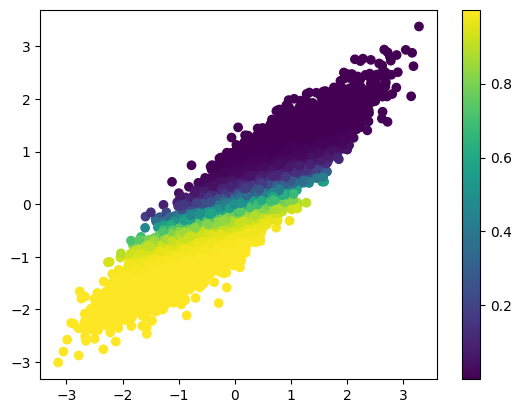

In [199]:
model.eval()
c = [model(torch.tensor([h, w], dtype=torch.float)).detach().numpy() for h, w in zip(H_scaled, W_scaled)]
plt.scatter(H_scaled, W_scaled, c =c)
plt.colorbar()


**Usage** of AI: *COMMENT HERE*

## Optional exercises

(These exercises do not have to be done. They give no points. However, we provide feedback on your answers)

### A.1 Gaussian Process Regression in the real world

**Reading Material: Murphy 15.1 + 15.2 (up to and including 15.2.3)**

 Let's also now take a look at some real world data. Consider for example, some climate data. Below, I have some data gathered by the [NASA Goddard Institute for Space Studies](https://data.giss.nasa.gov/gistemp/graphs_v4/). This data presents the Land-Ocean Temperature Index, which is the deviation from the mean of the 1951-1980 average temperatures. This measurement is given in degrees Celsius.

   Since measuring global temperature will naturally be a noisy process (things like volcanic eruptions may drag some years down; the measurements in the 1880s were likely not as precise as they are now, etc.), we would assume that the data are not perfect, noiseless measurements.

   Use the data provided below to first, reshape the arrays into the correct shapes, fit the data using your `posteriors` function.

   The $l$ parameter and the $\sigma_y$ parameters are known as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)), which are parameters whose values are used to control the learning process. These parameters cannot be learned through training a machine learning model and instead need to be explored via a grid or random search, in addition to the training of the model itself. This is a big area of the "practical ML" world and those who are good at automatic [hyperparameter tuning](https://www.oreilly.com/library/view/evaluating-machine-learning/9781492048756/ch04.html) can go on to build awesome tools like Google's [AutoML](https://cloud.google.com/automl-tables).


**Your task**

Determine the your preferred choice of hyper parameters `alpha`, `sigma_y` and `l`, and visualize the results, and discuss your choice. There's no "fully correct" choice here, but consider approximately how "noisy" the tempeature deviation is, and consider that the $l$ parameter here effectively controls the timescale of correlations in the data that we are interested in. Plot the results of a few settings of the hyperparameters that you tried, state your final preferred choice, and discuss why you chose it.
(2pt)



In [200]:
years = np.array([1880., 1881., 1882., 1883., 1884., 1885., 1886., 1887., 1888.,
       1889., 1890., 1891., 1892., 1893., 1894., 1895., 1896., 1897.,
       1898., 1899., 1900., 1901., 1902., 1903., 1904., 1905., 1906.,
       1907., 1908., 1909., 1910., 1911., 1912., 1913., 1914., 1915.,
       1916., 1917., 1918., 1919., 1920., 1921., 1922., 1923., 1924.,
       1925., 1926., 1927., 1928., 1929., 1930., 1931., 1932., 1933.,
       1934., 1935., 1936., 1937., 1938., 1939., 1940., 1941., 1942.,
       1943., 1944., 1945., 1946., 1947., 1948., 1949., 1950., 1951.,
       1952., 1953., 1954., 1955., 1956., 1957., 1958., 1959., 1960.,
       1961., 1962., 1963., 1964., 1965., 1966., 1967., 1968., 1969.,
       1970., 1971., 1972., 1973., 1974., 1975., 1976., 1977., 1978.,
       1979., 1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987.,
       1988., 1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996.,
       1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005.,
       2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014.,
       2015., 2016., 2017., 2018., 2019., 2020.])
temperature_index = np.array([-0.16, -0.08, -0.1 , -0.16, -0.28, -0.33, -0.31, -0.36, -0.17,
       -0.1 , -0.35, -0.22, -0.27, -0.31, -0.3 , -0.23, -0.11, -0.11,
       -0.27, -0.17, -0.08, -0.15, -0.27, -0.37, -0.47, -0.26, -0.22,
       -0.38, -0.43, -0.48, -0.43, -0.44, -0.36, -0.34, -0.15, -0.14,
       -0.35, -0.46, -0.3 , -0.28, -0.27, -0.19, -0.28, -0.26, -0.27,
       -0.22, -0.11, -0.22, -0.2 , -0.36, -0.16, -0.1 , -0.16, -0.29,
       -0.13, -0.2 , -0.15, -0.03, -0.01, -0.02,  0.12,  0.18,  0.06,
        0.09,  0.2 ,  0.09, -0.07, -0.03, -0.11, -0.11, -0.18, -0.07,
        0.01,  0.08, -0.13, -0.14, -0.19,  0.05,  0.06,  0.03, -0.03,
        0.06,  0.03,  0.05, -0.2 , -0.11, -0.06, -0.02, -0.08,  0.05,
        0.03, -0.08,  0.01,  0.16, -0.07, -0.01, -0.1 ,  0.18,  0.07,
        0.16,  0.26,  0.32,  0.14,  0.31,  0.16,  0.12,  0.18,  0.32,
        0.39,  0.27,  0.45,  0.41,  0.22,  0.23,  0.32,  0.45,  0.33,
        0.46,  0.61,  0.38,  0.39,  0.54,  0.63,  0.62,  0.54,  0.68,
        0.64,  0.67,  0.55,  0.66,  0.72,  0.61,  0.65,  0.68,  0.75,
        0.9 ,  1.02,  0.93,  0.85,  0.98,  1.02])

Your answer

**Usage** of AI: *COMMENT HERE*

### A.2. Star, Galaxy, or Quasar?



*Ref: Murphy 8.3.7, Bishop 4.3.4*


![alt text](https://www.sdss.org/wp-content/uploads/2014/05/segue.jpg)


In this problem, we will be extending our Pytorch logististic regression model to predict whether an observed object is a star, galaxy, or quasar.

**The Data**

We will be using data collected by the Sloan Digital Sky Survey ([SDSS](http://www.sdss.org/)) and released as part of Data Release 14. SDSS is a multi-spectral and spectroscopic survey telescope at Apache Point Observatory in New Mexico, USA.

The telescope uses a camera of 30 CCDs which observe in different optical filter bands (u,g,r,i,z). The data used here is freely publicly available.

Therefore we will be importing a table of 10,000 objects, for each of which we have the following information:
- class = tells us whether the object is a GALAXY, STAR, or QSO ("quasi-stellar object" or [quasar](https://en.wikipedia.org/wiki/Quasar))
- objid = object identifiier
- specobjid = another object ID, this time for spectroscopic observations
- ra = [Right Ascension](https://en.wikipedia.org/wiki/Right_ascension)
- dec = Declination
- mjd = date of observation


Magnitude in each of the following [filters](http://skyserver.sdss.org/dr1/en/proj/advanced/color/sdssfilters.asp):
- u
- g
- r
- i
- z

A number of attributes of the image that contained the object when imaged by SDSS:
- run = number that identifies a specific scan
- camcol = number that indicates which part of a CCD was used
- field = indicates when in the scan the object was imaged
- rerun = indicates how the image was processed
- fiberid
- plate

The last two items refer to how spectroscopic observations are taken by SDSS. The instruments use ciruclar metal plates that position optical fibers via holes drilled at the locations of objects in an image. The fibers are fed into the spectrographs. Each plate is numbered and so is each fiber. The reason we have these items in our datatable is because spectrographic observations are how SDSS determines

- [redshift](https://en.wikipedia.org/wiki/Redshift),

the last item of information we have for our objects. We will not be needing almost any of the imaging data, so you don't need to understand how SDSS works, but if you're curious, you can read about it [here](http://www.sdss3.org/dr9/imaging/imaging_basics.php).

1. Let's import out data:

In [201]:
# Let's import the aforementioned data
!wget https://raw.githubusercontent.com/klukosiute/ml4pha_datasets/main/Skyserver_SQL2_27_2018%206_51_39%20PM.csv

--2024-04-25 14:23:50--  https://raw.githubusercontent.com/klukosiute/ml4pha_datasets/main/Skyserver_SQL2_27_2018%206_51_39%20PM.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-04-25 14:23:50 ERROR 404: Not Found.



In [202]:
sdss_df = pd.read_csv('/content/Skyserver_SQL2_27_2018 6_51_39 PM.csv', skiprows=0)
sdss_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/Skyserver_SQL2_27_2018 6_51_39 PM.csv'

**Usage** of AI: *COMMENT HERE*

2. Exploring data and understanding it is an important part of the machine learning mindset. In that spirit, find out how many objects of each class are in the catalog. How do you think this might influence how often objects are classified as a given class?

In [ ]:
sdss_df['class'].value_counts()

**Usage** of AI: *COMMENT HERE*

We should end up with approx. the same amount of galaxies as stars and then very few quasars.

3. Make histograms of redshift for stars, galaxies, and quasars. What are the results telling you?

In [ ]:
# Your code here

**Usage** of AI: *COMMENT HERE*

Stars are all with the Milky Way, so they get small redshifts (they're close), that can have both positive and negative redshifts since there's nothing making them preferrentially toward or away from us. Galaxies are further and preferrentially move away from us.

Before we can move onto training a model that predicts objects, we need to do a few things to our dataset.

4. We don't need to know everything about astronomy to already understand that there are a number of data columns that won't be related to the target variable **class** in a meaningful way and may lead to only accidental correlations. Therefore we choose to drop these. This can be done with the [df.drop()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) function. Which data items do you see as appropriate to remove from the input data?

In [ ]:
# Your code here

**Usage** of AI: *COMMENT HERE*

Next, we need to convert our text labels (STAR, GALAXY, or QSO) into digits. Pytorch has a particular curiosity that, for the `CrossEntropyLoss`, the inputs need to be not one-hot encoded vectors but rather simply the indices of the class. However, the output of the model **should** be a vector of length 3 because the `CrossEntropyLoss` module converts your class indices into one-hot vectors internally.

Therefore, write a function that takes as input the numpy array `sdss_df['class'].values`, which is an array of the strings STAR, GALAXY, or QSO, and converts it to an array that contains 0,1, or 2 as entries.

5. Create your target array `T` using your function.

In [ ]:
# Your code here

**Usage** of AI: *COMMENT HERE*

6. Now build your input array `X` by feature scaling each of your feature columns and combining the features into a numpy array.

In [ ]:
# Your code here

**Usage** of AI: *COMMENT HERE*

Now the final data processing step: we will need a subset of the data to impartially evaluate the performance of our classifier.

7. First, shuffle your X and T arrays, in such a way that each row still corresponds to each row! Split your target array `T` into two arrays: `T_train` and `T_test` and corresponding two `X_train` and `X_test` arrays, where the train test contains 90% of the datapoints and the test dataset contains 10% of the datapoints.

In [ ]:
# Your code here

**Usage** of AI: *COMMENT HERE*

8. Now we are ready to move onto the Pytorch part of the exercises. As in the exercises, convert your train and test arrays to torch tensors.

In [ ]:
# Your code here

**Usage** of AI: *COMMENT HERE*

9. Extend your code for the Logistic Regression Pytorch model from the exercises for multiclass classification with more than two input parameters. Train your code again with the  cross entropy loss, using the SGD optimizer. You can use 15000 steps and a learning rate 0.02 as a starting point.

In [ ]:
# Your code here

**Usage** of AI: *COMMENT HERE*

Although we aim to minimize the loss function, it hardly tells us as humans how well the classification scheme is performing. To get a better understanding of performance, we look at *accuracy*, or the fraction of correct predictions from total predictions.

10. Define the function `accuracy` which takes as inputs the targets and the predictions by the model and use it to evaluate the accuracy of our logistic regression model on the train and test datasets.

In [ ]:
def accuracy(targets, predictions):
    # Your code here
    return NotImplementedError


# Your code here

**Usage** of AI: *COMMENT HERE*

### A.3 Sigmoid

Verify that the derivative of the sigmoid
$$
\sigma(a) = \frac{1}{1 + \exp(-a)} \, ,
$$
is
$$
\frac{d\sigma}{da} = \sigma(1 - \sigma) \, .
$$

Your answer here

**Usage** of AI: *COMMENT HERE*